In [66]:
import umap
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score 
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
from sklearn.cross_decomposition import PLSRegression

# Preparing MNIST dataset

In [2]:
mnist = fetch_openml("mnist_784", version = 1)
labels = mnist.target.astype(int)
print(mnist.data.shape)

(70000, 784)


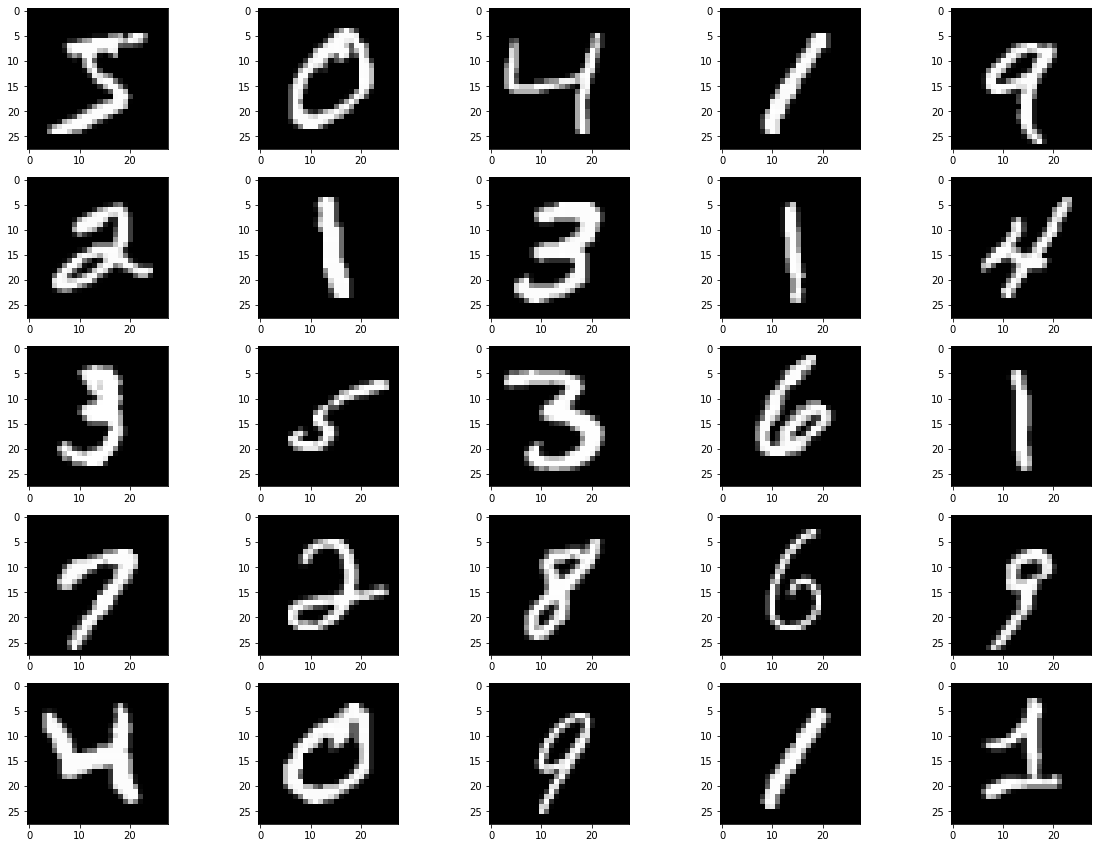

In [3]:
plt.figure(figsize = (20, 15))

for i in range (25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(mnist.data.loc[i].values.reshape(28, 28), cmap = plt.get_cmap("gray"))
    
plt.show()

In [4]:
N_points = 10000
X = np.log10(mnist.data + 1)

In [5]:
np.random.seed(42)
random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
X = X.loc[random_indices,:]
labels = labels[random_indices]

# PCA and UMAP results of application to MNIST dataset

## PCA

In [37]:
pca = PCA(n_components = 2)
pca.fit(X)
X_reduced = pca.transform(X)
data_pca = pd.DataFrame({"PC1": X_reduced[:, 0], "PC2": X_reduced[:, 1], 
                         "Digit": labels})
data_pca["Digit"] = data_pca["Digit"].astype(str)
figure = px.scatter(data_pca, x = "PC1", y = "PC2", color = "Digit", 
                   title = "PCA results of application to MNIST in 2D")

figure.show()

In [38]:
pca = PCA(n_components = 3)
pca.fit(X)
X_reduced = pca.transform(X)
data3d_pca = pd.DataFrame({"PC1": X_reduced[:, 0], "PC2": X_reduced[:, 1], 
                           "PC3": X_reduced[:, 2], "Digit": labels})
data3d_pca["Digit"] = data3d_pca["Digit"].astype(str)
figure = px.scatter_3d(data3d_pca, x = "PC1", y = "PC2", z = "PC3",
                       color = "Digit", title = "PCA results of application to MNIST in 3D")

figure.show()

Text(0, 0.5, 'Explained variance')

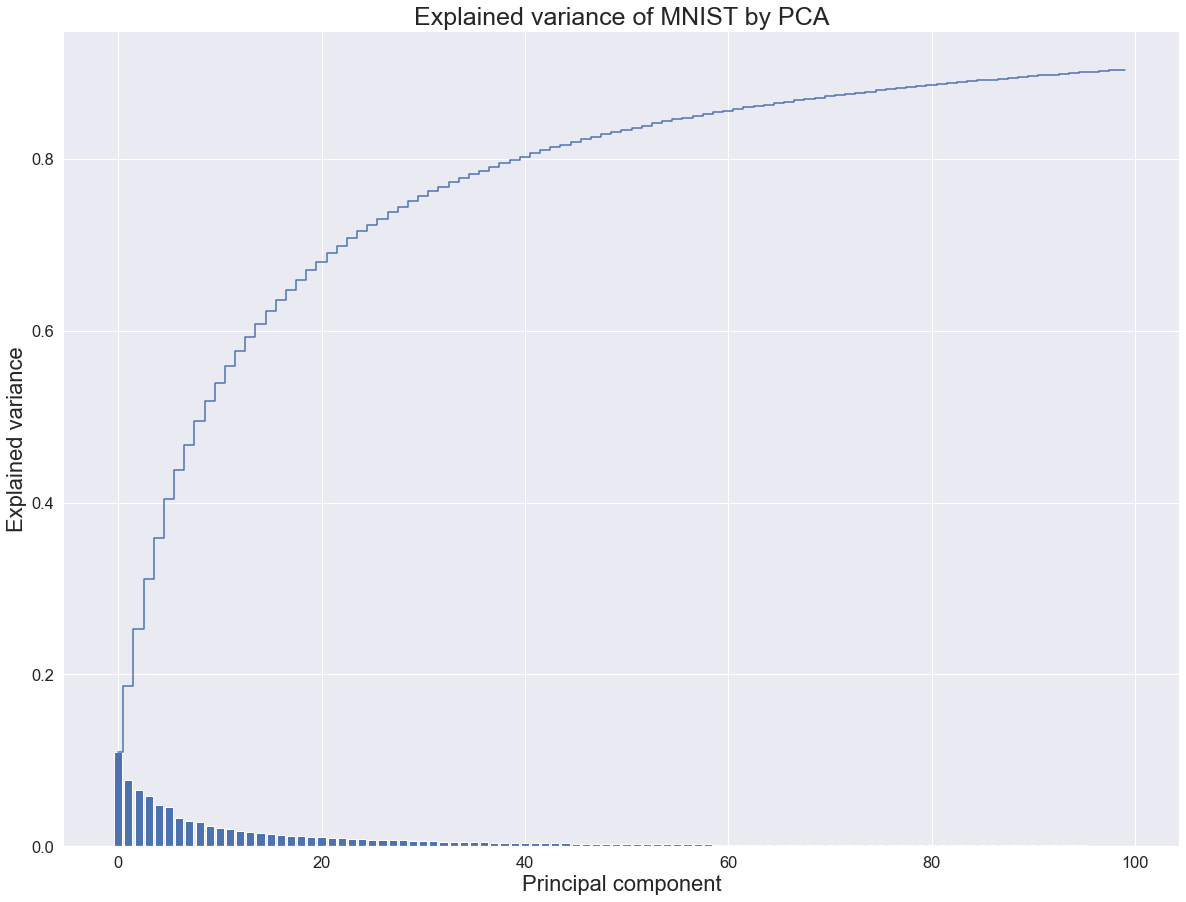

In [35]:
pca = PCA(n_components = 100)
pca.fit(X)
X_reduced = pca.transform(X)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = np.cumsum(explained_variance_ratio)
figure = plt.figure(figsize = (20, 15))
plt.bar(range(0, len(explained_variance_ratio)), 
        explained_variance_ratio,
        label = "Explained variance of component")
plt.step(range(0, len(cumulative_sum)), 
         cumulative_sum, 
         where = "mid", 
         label= "Cumulative explained variance")
plt.title("Explained variance of MNIST by PCA", fontsize = 25)
plt.xlabel("Principal component", fontsize = 22)
plt.ylabel("Explained variance", fontsize = 22)

## UMAP

In [43]:
opt_perp = int(np.round(np.sqrt(X.shape[0]), 0))
X_reduced = PCA(n_components = 62).fit_transform(X)

umap_embedding = umap.UMAP(n_components = 2, n_neighbors = opt_perp,
                           init = X_reduced[:, 0:2], min_dist = 0.3, 
                           n_epochs = 1000, random_state = 42, 
                           verbose = 0).fit_transform(X_reduced)

data_umap = pd.DataFrame({"UMAP1": umap_embedding[:, 0], "UMAP2": umap_embedding[:, 1], 
                          "Digit": labels})
data_umap["Digit"] = data_umap["Digit"].astype(str)
figure = px.scatter(data_umap, x = "UMAP1", y = "UMAP2", color = "Digit", 
                   title = "UMAP results of application to MNIST in 2D")

figure.show()

/Users/RomanGorelsky/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [45]:
umap_embedding = umap.UMAP(n_components = 3, n_neighbors = opt_perp,
                           init = X_reduced[:, 0:3], min_dist = 0.3, 
                           n_epochs = 1000, random_state = 42, 
                           verbose = 0).fit_transform(X_reduced)

data3d_umap = pd.DataFrame({"UMAP1": umap_embedding[:, 0], "UMAP2": umap_embedding[:, 1],
                            "UMAP3": umap_embedding[:, 2], "Digit": labels})
data3d_umap["Digit"] = data3d_umap["Digit"].astype(str)
figure = px.scatter_3d(data3d_umap, x = "UMAP1", y = "UMAP2", z = "UMAP3", 
                    color = "Digit", title = "UMAP results of application to MNIST in 3D")

figure.show()

/Users/RomanGorelsky/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Variation explained by components

## PCA

In [46]:
pca = PCA(n_components = X.shape[1]).fit(X)
pca_comps = PCA().fit_transform(X)
print(pca.explained_variance_ratio_[0])

0.10945209784606938


### Computation with Partial Least Squares procedure

In [47]:
PCA_matrix = pd.DataFrame(pca_comps[:, 0:1])
pls = PLSRegression(n_components = 1)
pls.fit(PCA_matrix, X)
y_pred = pls.predict(PCA_matrix)
print(r2_score(X, y_pred, multioutput = "variance_weighted"))

0.10945209784606928


#### Verification of PLS correctness

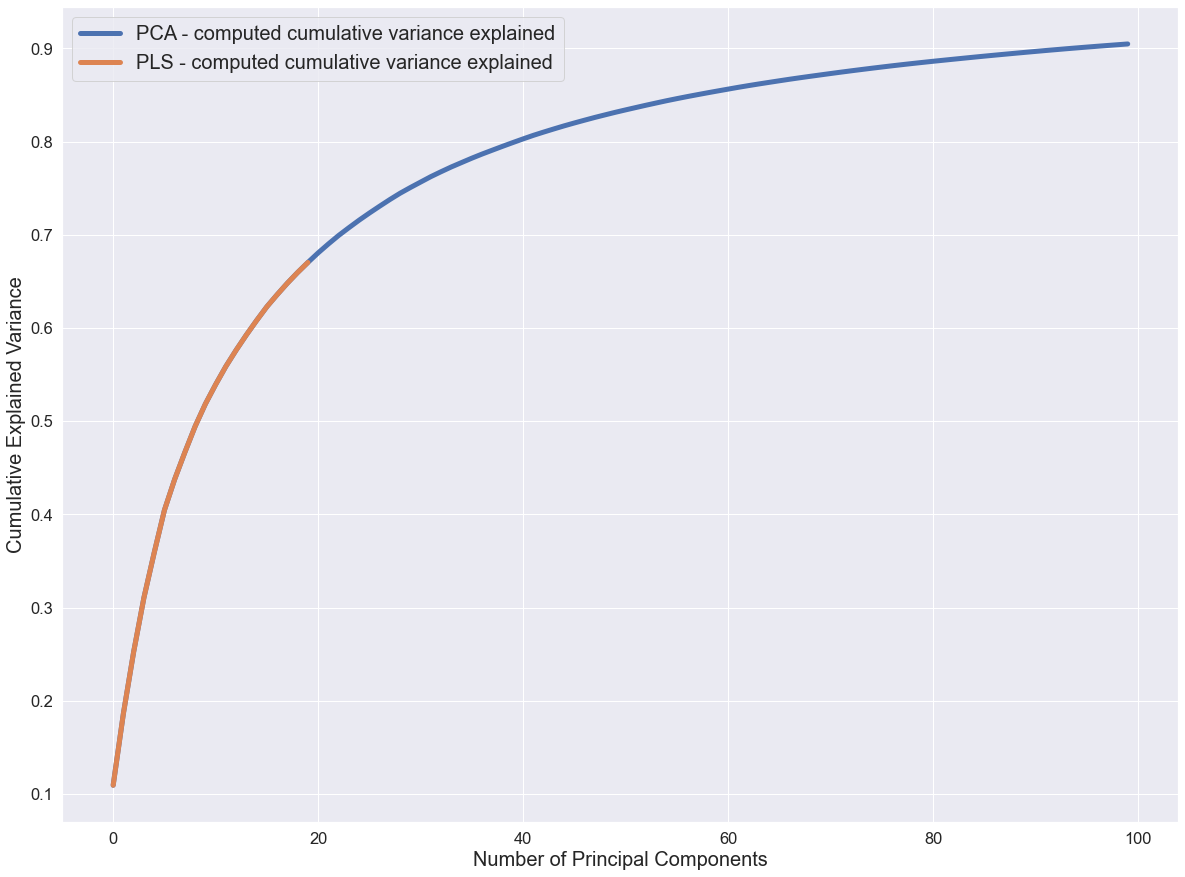

In [48]:
predicted_var_expl = []

for i in range(1, 21):
    PCA_matrix_current = pd.DataFrame(pca_comps[:, 0 : i])
    pls_current = PLSRegression(n_components = i)
    pls_current.fit(PCA_matrix_current, X)
    y_pred_current = pls_current.predict(PCA_matrix_current)
    predicted_var_expl.append(r2_score(X, y_pred_current,
                              multioutput = "variance_weighted"))
    
sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 15))
plt.plot(np.cumsum(pca.explained_variance_ratio_[0 : 100]), linewidth=5)
plt.plot(predicted_var_expl, linewidth = 5)
plt.ylabel("Cumulative Explained Variance", fontsize = 20)
plt.xlabel("Number of Principal Components", fontsize = 20)
plt.legend(["PCA - computed cumulative variance explained",
            "PLS - computed cumulative variance explained"],
            fontsize = 20)
plt.show()

## UMAP

In [49]:
UMAP_matrix = pd.DataFrame(umap_embedding[:, 0:1])
pls = PLSRegression(n_components = 1)
pls.fit(UMAP_matrix, X)
y_pred = pls.predict(UMAP_matrix)
print(r2_score(X, y_pred, multioutput = "variance_weighted"))

0.07116372462558536


## Explained Variance by Components

In [51]:
N_iter = 3 
N_comps = 3

N_points_list = [5000, 10000, 15000]
perp_list = [50, 100, 150] 
min_dist_list = [0.1, 0.2, 0.3]

predicted_var_expl_matrix = np.zeros(shape = (N_iter, N_comps))
predicted_var_expl_umap_matrix = np.zeros(shape = (N_iter, N_comps))

for j in range(N_iter):
    
    # MNIST variance explained by PCA components 
    
    np.random.seed(j)
    X = np.log10(mnist.data + 1) 
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], size = N_points_list[j],
                                      replace = False)
    X_sample = X.loc[random_indices, :] 
    labels_sample = labels[random_indices]
    pca_comps_sample = PCA(n_components = N_comps).fit_transform(X_sample)
    predicted_var_expl = []
    
    for i in range(1, (N_comps + 1)) :
        
        PCA_matrix_current = pd.DataFrame(pca_comps_sample[:, 0:i])
        pls_current = PLSRegression(n_components = i)
        pls_current.fit(PCA_matrix_current, X_sample)
        y_pred_current = pls_current.predict(PCA_matrix_current)
        predicted_var_expl.append(r2_score(X_sample, y_pred_current,
                                           multioutput= "variance_weighted"))
        
    predicted_var_expl_matrix[j,:] = predicted_var_expl
    
    # MNIST variance explained by UMAP components
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], size = N_points,
                                      replace = False)
    X_sample = X.loc[random_indices, :] 
    labels_sample = labels[random_indices]
    opt_perp = int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = 62).fit_transform(X_sample)
    
    umap_embedding_sample = umap.UMAP(n_components = N_comps,
                                      n_neighbors = opt_perp,
                                      init = X_reduced_sample[:, 0 : N_comps],
                                      min_dist = min_dist_list[j],
                                      n_epochs = 1000, verbose = 0).fit_transform(X_reduced_sample)
    predicted_var_expl_umap = []

    for i in range(1, (N_comps + 1)):

        UMAP_matrix_current = pd.DataFrame(umap_embedding_sample[:, 0:i])
        pls_current = PLSRegression (n_components = i)
        pls_current.fit(UMAP_matrix_current, X_sample)
        y_pred_current = pls_current.predict(UMAP_matrix_current)
        predicted_var_expl_umap.append(r2_score(X_sample, y_pred_current, multioutput = "variance_weighted"))

    predicted_var_expl_umap_matrix[j,:] = predicted_var_expl_umap

print("MNIST variance explained by PCA components:")
print(predicted_var_expl_matrix, end = "\n")
print("MNIST variance explained by UMAP components:")
print(predicted_var_expl_umap_matrix, end = "\n")

MNIST variance explained by PCA components:
[[0.10780598 0.18642903 0.25086806]
 [0.10939031 0.18671329 0.25279746]
 [0.10868969 0.18615405 0.25226694]]
MNIST variance explained by UMAP components:
[[0.07029932 0.11632829 0.15756784]
 [0.06657813 0.11251522 0.15850207]
 [0.07442924 0.11762925 0.16580295]]


## Plot of Components Variance Explained

In [75]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name = "PCA variance explained",
    x = ["1", "2", "3"], 
    y = np.mean(predicted_var_expl_matrix, axis = 0),
    error_y = dict(type = "data", 
                   array = [2 * np.std(predicted_var_expl_matrix[:, 0], axis = 0), 
                            2 * np.std(predicted_var_expl_matrix[:, 1], axis = 0), 
                            2 * np.std(predicted_var_expl_matrix[:, 2], axis = 0)])
))
fig.add_trace(go.Bar(
    name = "UMAP variance explained",
    x = ["1", "2", "3"], 
    y = np.mean(predicted_var_expl_umap_matrix, axis = 0),
    error_y = dict(type = "data", 
                   array = [2 * np.std(predicted_var_expl_umap_matrix[:, 0], axis = 0), 
                            2 * np.std(predicted_var_expl_umap_matrix[:, 1], axis = 0), 
                            2 * np.std(predicted_var_expl_umap_matrix[:, 2], axis = 0)])
))
fig.update_layout(barmode = "group")
fig.show()

## Biological Variantion

In [76]:
N_comps = 3
N_points = 10000
mnist = fetch_openml("mnist_784", version = 1)
labels = mnist.target.astype(int) 
X = np.log10(mnist.data + 1)

# Subsample MNIST data down to 10 000 images 

np.random.seed(42)
random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
X = X.loc[random_indices, :]
labels = labels[random_indices]

# Compute top 3 PCA components on the subsampled MNIST data

pca = PCA(n_components = N_comps).fit(X)
pca_comps = PCA().fit_transform(X)

# Compute top 3 UMAP components on the subsampled MNIST data

opt_perp = int(np.round(np.sqrt(X.shape[0]), 0))
X_reduced = PCA(n_components = 62).fit_transform(X)
umap_embedding = umap.UMAP(n_components = N_comps, n_neighbors = opt_perp,
                           init = X_reduced[:, 0 : N_comps],
                           min_dist = 0.3, n_epochs = 1000, random_state=123,
                           verbose = 0).fit_transform(X_reduced)

/Users/RomanGorelsky/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



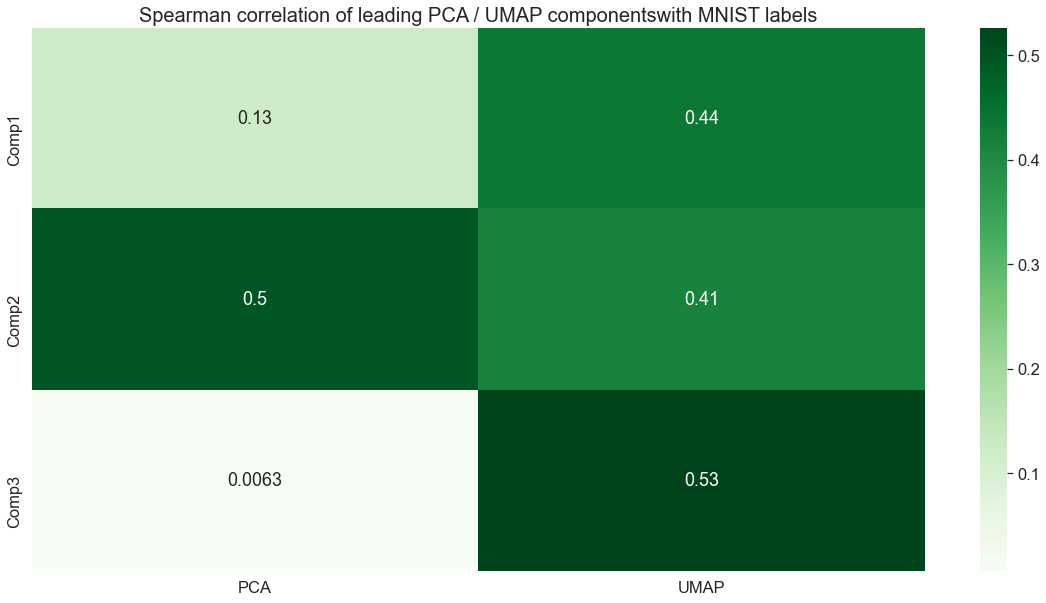

In [78]:
#Pairwise correlations between MNIST labels and PCA / UMAP components

rho_matrix = np.zeros(shape = (2, 3))

for i in range(N_comps):
    
    rho, pval = spearmanr(pca_comps[:, i], labels)
    rho_matrix[0, i] = abs(rho)

for i in range(N_comps):
    
    rho, pval = spearmanr(umap_embedding[:, i], labels)
    rho_matrix[1, i] = abs(rho)

rho_df = pd.DataFrame(rho_matrix, columns = ["Comp1", "Comp2", "Comp3"],
                      index = ["PCA", "UMAP"])
sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 10))
sns.heatmap(rho_df.T, cmap = "Greens", annot = True)
plt.title("Spearman correlation of leading PCA / UMAP components" +
          "with MNIST labels", fontsize = 20)
plt.show()

In [59]:
# Variance in MNIST labels explained by PC1

pca = PCA(n_components = X.shape[1]).fit(X)
pca_comps = PCA().fit_transform(X)
PCA_matrix = pd.DataFrame(pca_comps[:, 0 : 1])
pls = PLSRegression(n_components = 1)
pls.fit(PCA_matrix, labels)
y_pred = pls.predict(PCA_matrix)
print("PC1: ", r2_score(labels, y_pred, multioutput = "variance_weighted"), end = "\n")

# Variance in MNIST labels explained by UMAP1

UMAP_matrix = pd.DataFrame(umap_embedding[:, 0 : 1])
pls = PLSRegression(n_components = 1)
pls.fit(UMAP_matrix, labels)
y_pred = pls.predict(UMAP_matrix)
print("UMAP1: ", r2_score (labels, y_pred, multioutput = "variance_weighted"), end = "\n")

PC1:  0.023018192576503282
UMAP1:  0.1666563601927593


In [60]:
my_df_comps = pd.DataFrame({"LABELS": labels,
                           "PC1": np.array(PCA_matrix).flatten(),
                           "UMAP1": np.array(UMAP_matrix).flatten()})

In [61]:
smf.ols(formula = "LABELS ~ PC1", data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     235.6
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           1.45e-52
Time:                        15:53:07   Log-Likelihood:                -24741.
No. Observations:               10000   AIC:                         4.949e+04
Df Residuals:                    9998   BIC:                         4.950e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4724      0.029    155.691      0.000       4.416       4.529
PC1           -0.0689      0.004    -15.348      0.000      -0.078      -0.060
==============================================================================
Omnibus:                    24160.971   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              684.582
Skew:                           0.007   Prob(JB):                    2.21e-149
Kurtosis:                       1.718   Cond. No.                         6.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
smf.ols(formula = "LABELS ~ UMAP1", data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     1999.
Date:                Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:53:09   Log-Likelihood:                -23945.
No. Observations:               10000   AIC:                         4.789e+04
Df Residuals:                    9998   BIC:                         4.791e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6549      0.032    113.436      0.000       3.592       3.718
UMAP1         -0.3890      0.009    -44.715      0.000      -0.406      -0.372
==============================================================================
Omnibus:                     8734.587   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              608.121
Skew:                          -0.068   Prob(JB):                    8.87e-133
Kurtosis:                       1.800   Cond. No.                         4.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Cumulative Variance Explained Change

In [63]:
N_iter = 3
N_comps = 3

N_points_list = [5000, 10000, 15000]
min_dist_list = [0.1, 0.2, 0.3]
perp_list = [90, 100, 110]
predicted_var_expl_labels_matrix = np.zeros(shape = (N_iter, N_comps))
predicted_var_expl_labels_umap_matrix=np.zeros(shape=(N_iter, N_comps))
                 
for j in range(N_iter):
                 
    # Variance in MNIST labels explained by PCA components 
    np.random.seed(j)
                 
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], 
                                      size = N_points_list[j],
                                      replace = False)
    X_sample = X.loc[random_indices, :]
    labels_sample = labels[random_indices]
    pca_comps_sample = PCA(n_components = N_comps).fit_transform(X_sample)

    predicted_var_expl_labels = []
    
    for i in range(1, (N_comps + 1)) :

        PCA_matrix_current_labels = pd.DataFrame(pca_comps_sample[:, 0 : i])
        pls_current_labels = PLSRegression(n_components = i)
        pls_current_labels.fit(PCA_matrix_current_labels, labels_sample)
        y_pred_current_labels = pls_current_labels.predict(PCA_matrix_current_labels)
        predicted_var_expl_labels.append(r2_score(labels_sample, 
                                                  y_pred_current_labels, 
                                                  multioutput = "variance_weighted"))

    predicted_var_expl_labels_matrix[j,:] = predicted_var_expl_labels

    # Variance in MNIST labels explained by UMAP components

    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], 
                                      size = N_points, 
                                      replace = False)
    X_sample = X.loc[random_indices, :]
    labels_sample = labels[random_indices]
    opt_perp = int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = 62).fit_transform(X_sample)
    umap_embedding_sample = umap.UMAP(n_components = N_comps,
                                      n_neighbors = opt_perp,
                                      init = X_reduced_sample[:, 0 : N_comps],
                                      min_dist = min_dist_list[j],
                                      n_epochs = 1000, verbose = 0).fit_transform(X_reduced_sample)
    predicted_var_expl_labels_umap = []

    for i in range(1, (N_comps + 1)):

        UMAP_matrix_current_labels = pd.DataFrame(umap_embedding_sample[:, 0 : i])
        pls_current_labels_umap = PLSRegression(n_components = i)
        pls_current_labels_umap.fit(UMAP_matrix_current_labels, labels_sample)
        y_pred_current_labels_umap = pls_current_labels_umap.predict(UMAP_matrix_current_labels)
        predicted_var_expl_labels_umap.append(r2_score(labels_sample,
                                                       y_pred_current_labels_umap, 
                                                       multioutput = "variance_weighted"))
    
    predicted_var_expl_labels_umap_matrix[j, :] = predicted_var_expl_labels_umap

In [64]:
print("Variance in MNIST labels explained by PCA components: ")
print(predicted_var_expl_labels_matrix, end = "\n")
print("Variance in MNIST labels explained by UMAP components: ")
print(predicted_var_expl_labels_umap_matrix, end = "\n")

Variance in MNIST labels explained by PCA components: 
[[0.03418984 0.27663261 0.29223446]
 [0.0265549  0.28409257 0.28739842]
 [0.03096174 0.27898829 0.2794116 ]]
Variance in MNIST labels explained by UMAP components: 
[[0.11181146 0.32764867 0.44387308]
 [0.06110166 0.49407407 0.49427133]
 [0.14295283 0.3696435  0.41228219]]


In [73]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name = "PCA variance explained",
    x = ["1", "2", "3"], 
    y = np.mean(predicted_var_expl_labels_matrix, axis = 0),
    error_y = dict(type = "data", 
                   array = [2 * np.std(predicted_var_expl_labels_matrix[:, 0], axis = 0), 
                            2 * np.std(predicted_var_expl_labels_matrix[:, 1], axis = 0), 
                            2 * np.std(predicted_var_expl_labels_matrix[:, 2], axis = 0)])
))
fig.add_trace(go.Bar(
    name = "UMAP variance explained",
    x = ["1", "2", "3"], 
    y = np.mean(predicted_var_expl_labels_umap_matrix, axis = 0),
    error_y = dict(type = "data", 
                   array = [2 * np.std(predicted_var_expl_labels_umap_matrix[:, 0], axis = 0), 
                            2 * np.std(predicted_var_expl_labels_umap_matrix[:, 1], axis = 0), 
                            2 * np.std(predicted_var_expl_labels_umap_matrix[:, 2], axis = 0)])
))
fig.update_layout(barmode = "group")
fig.show()